In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# utilities lib
from utils import shuffle, generate_cards, distribute, \
mergePrivateAndPublic, calculateProbability, executeTrade

# import players
import players as plys

# import publicboard
import publicboard

# Initiate Game

In [21]:
# number of market makers
n_market_makers = 4 # this is always fixed
suits = ['S', 'C', 'D', 'H'] 
# number of spectator
n_spectator = 1 # either 0 or 1

# total number of players
n_total_players = n_market_makers + n_spectator

# number of cards per suit
n_cards_per_suit = 13
# n_total_cards = n_cards*n_market_makers

# maximum bid-ask spread
max_bid_ask_spread = 5


In [22]:
###### Inititate Game ######
# 1. generate cards
deck = generate_cards(n_cards_per_suit, suits)
print('{} Cards generated.'.format(len(deck)))

# 2. shuffle deck
deck = shuffle(deck)
print('Cards shuffled.')

# 3. distribute cards
if n_total_players == 4:
    # distribute 4 cards for MM
    privateInfoMM1, privateInfoMM1,\
    privateInfoMM1, privateInfoMM1 = [distribute(deck, 4) for _ in range(4)]
elif n_total_players == 5:
    # distribute 5 cards for MM
    privateInfoMM1, privateInfoMM2,\
    privateInfoMM3, privateInfoMM4 = [distribute(deck, 5) for _ in range(4)]
    
    # 3 cards for spectator
    privateInfoSpec = distribute(deck, 3)
print('Players obtained private information.')
print('{} Cards left'.format(len(deck)))

52 Cards generated.
Cards shuffled.
Players obtained private information.
29 Cards left


# 2. Create Players and Publicboard
1. Created players and public boad
2. Simulated the action of revealing cards from the deck. Updated the public probabilities and the perceived probabilities simultaneously
3. Simulated trades (but without the ability to set bid and ask price yet, currently randomised with ask<bid<=ask+maxspread),
   ledger update(zero sum between 2 players tested), public bid-ask record, perceived risk visualisation.
4. Implemented viz functions for all players.

## Aim
1. To illustrate how classes and functions work
2. To showcase arbitrage alert and risk visualisations functionalities.

In [23]:
# create players
p1 = plys.MarketMaker(privateInfoMM1, suits[0], suits, 13)

p2 = plys.MarketMaker(privateInfoMM2, suits[1], suits, 13)

p3 = plys.MarketMaker(privateInfoMM3, suits[2], suits, 13)

p4 = plys.MarketMaker(privateInfoMM4, suits[3], suits, 13)

p5 = plys.Player(privateInfoSpec, 'Spectator', suits, 13)

# for convenience
players = [p1, p2, p3, p4 ,p5]

In [26]:
# create public board
pb = publicboard.PublicBoard()

In [27]:
#  example of card reveal, copy deck to avoid regenerating deck of cards
tempDeck = deck.copy()
num = 1
print(len(tempDeck))

print('The last card is ', tempDeck[-1])

# reveal 10 cards consecutively
for action in range(29):
    
    pb.revealedFromPublicDeck(tempDeck)
    
    if action in [5, 15, 26]:
        pb.revealedCards.extend([p.revealPrivateCard(p.privateCards[0]) for p in players])
    elif action in [10, 20]:
        pb.revealedCards.extend([p.revealPrivateCard(p.privateCards[0]) for p in players if p.name != 'Spectator'])
    for player in players:
        player.updateProbability(num, pb.revealedCards)
    pb.updateProbability(num)
    num += 1
    
    
# display public information
pb.publicInformation
print(len(tempDeck))

29
The last card is  H 10
0


## Trade Executions 
While the private informations were revealed upfront to all the trades, this is not a representative situation of the actual trade. In actual trades, both the market maker and their counterparty implements their trading&pricing strategies  based on the influx of private and public information(probabilities). 

For example,
The higher the relative (public or private) probability of a suit being the last card, the higher the risk of holding the suit with a negative position.

## Arbitrage Alert
All market makers would receive an arbitrage alert when their pricing strategy allows their counterparty to take arbitrage opportunity. This is possible because all transaction between individual market maker and their counterparty has been recorded in market maker's ledger. Aside from alerting the market maker, the function also suggests pricing references to avoid arbitrage (MM has the power to ignore this, but rarely MM would want to create arbitrage opportunity).

For simulation, we just don't execute trade when the pricing creates arbitrage opportunity. Note that, in real game, mm will have to trade once its counterparty agrees on the pricing set by mm.

## Viz
Mid price and (perceived and private)probabilities can be visualised in the form of line plots. In theory, pricing strategy should be tied with market information. This is not the case here, where we just want to showcase that it is possible to extract insight (manually or automatically) from the vis. Possibly we can also reveal traders' preference and willingness to trade if we show a record of bid ask spread.


In [28]:
numContracts = np.random.randint(0, 5)
ask = np.random.randint(20, 35)
bid = np.random.randint(ask, ask + max_bid_ask_spread)
idx = 0
for action in range(0, 28):
    for trade in range(np.random.randint(8, 10)):
        idx += 1
        traded = False
        # generate unique players, disregard speculator (sampling without replacement)
        plys = players.copy()
        playerId = random.sample(range(0, 4), 2)
        playerA = plys[playerId[0]]
        playerB = plys[playerId[1]]
        plyInvolved = [playerA, playerB]
        
        # generate num of contracts to be traded
        numContracts = np.random.randint(1, 5)
        
        # generate bid ask price with ask lower than bid price
        ask = np.random.randint(20, 35)
        bid = np.random.randint(ask+1, ask + max_bid_ask_spread)        
        
        # simulate trading, generate contract from players involved
        if np.random.randint(0, 2):
            
            # market maker sells
            
            contract = plyInvolved[np.random.randint(0, 2)].name
            mm = playerA if contract == playerA.name else playerB
            cntParty = playerB if contract != playerB.name else playerA
            if not mm.arbitrageAlert(cntParty.name, [bid, ask]):             
                executeTrade(seller=mm, buyer=cntParty, bidAskPrice=[bid, ask], \
                     contract=contract, numContracts=numContracts, idx=idx, action=action, trade=trade)
                traded = True
            
        else:
            
            # market maker buys
            
            contract = plyInvolved[np.random.randint(0, 2)].name
            mm = playerA if contract == playerA.name else playerB
            cntParty = playerB if contract != playerB.name else playerA
            
            if not mm.arbitrageAlert(cntParty.name, [bid, ask]): 
                executeTrade(seller=cntParty, buyer=mm, bidAskPrice=[bid, ask], \
                     contract=contract, numContracts=numContracts, idx=idx, action=action, trade=trade)
                
                traded = True
        
        # update public board ith bid ask price if trade was successful
        if traded:
            pb.updateBidAsk(contract, [bid, ask], action, trade, idx)
        else:
            idx -= 1

Bid Price too low. Suggested Bid price 34
Bid Price too low. Suggested Bid price 33
Bid Price too low. Suggested Bid price 34
Bid Price too low. Suggested Bid price 32
Ask Price too high. Suggested Ask price 27
Bid Price too low. Suggested Bid price 31
Bid Price too low. Suggested Bid price 34
Ask Price too high. Suggested Ask price 20
Bid Price too low. Suggested Bid price 29
Ask Price too high. Suggested Ask price 24
Ask Price too high. Suggested Ask price 22
Ask Price too high. Suggested Ask price 20
Bid Price too low. Suggested Bid price 32
Bid Price too low. Suggested Bid price 35
Ask Price too high. Suggested Ask price 24
Ask Price too high. Suggested Ask price 20
Bid Price too low. Suggested Bid price 32
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 32
Ask Price too high. Suggested Ask price 30
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 27
Bid Price too low. Sugge

Ask Price too high. Suggested Ask price 20
Ask Price too high. Suggested Ask price 21
Bid Price too low. Suggested Bid price 38
Ask Price too high. Suggested Ask price 21
Bid Price too low. Suggested Bid price 38
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 23
Bid Price too low. Suggested Bid price 37
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 35
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 34
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 34
Ask Price too high. Sug

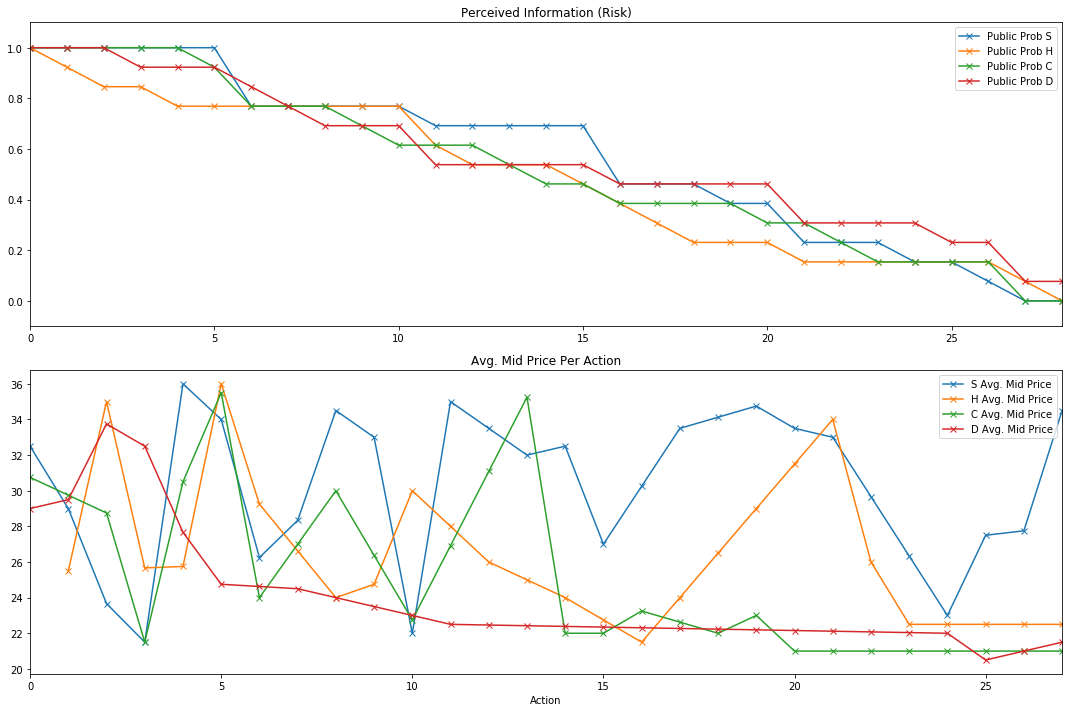

In [29]:
# todo 
# check why probability doesn't converge to 0 (try extend the x axis)
pb.viz()

# Ledgers

Inventories and cash at each action must sum to zero. This is just a sanity check. Also, export ledgers with .to_csv() for submissions.

In [32]:
for p in players[:4]:
    print(p.ledger.tail(1))

     Action CounterParty Contract Price Quantity Buy/Sell  S   C  D   H  Cash
108    27.5            D        S    35        2     Sell  6  11  2  -7  -423
     Action CounterParty Contract Price Quantity Buy/Sell   S   C  D  H  Cash
106    26.2            S        S   -35        2      Buy  -8  10  1  7  -119
     Action CounterParty Contract Price Quantity Buy/Sell   S    C   D   H  \
108    27.5            S        S   -35        2      Buy  -6  -12  -8  -4   

    Cash  
108  685  
     Action CounterParty Contract Price Quantity Buy/Sell  S   C  D  H  Cash
107    27.0            D        D   -23        1      Buy  8  -9  5  4  -143


In [33]:
p1.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
1,0.0,D,S,32,4,Sell,-4,0,0,0,128
4,0.3,C,C,-25,3,Buy,-4,3,0,0,53
5,0.4,C,S,-33,4,Buy,0,3,0,0,-79
6,0.5,C,S,-30,1,Buy,1,3,0,0,-109
10,1.0,C,S,32,3,Sell,-2,3,0,0,-13
11,1.1,H,S,-24,1,Buy,-1,3,0,0,-37
12,1.2,D,D,-30,4,Buy,-1,3,4,0,-157
14,1.4,C,S,31,1,Sell,-2,3,4,0,-126
15,1.5,D,S,-31,3,Buy,1,3,4,0,-219
16,1.6,D,S,-25,1,Buy,2,3,4,0,-244


In [34]:
p2.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
2,0.1,D,D,-35,1,Buy,0,0,1,0,-35
3,0.2,H,C,-28,4,Buy,0,4,1,0,-147
4,0.3,S,C,25,3,Sell,0,1,1,0,-72
5,0.4,S,S,33,4,Sell,-4,1,1,0,60
6,0.5,S,S,30,1,Sell,-5,1,1,0,90
7,0.6,D,D,-27,2,Buy,-5,1,3,0,36
8,0.7,D,C,36,4,Sell,-5,-3,3,0,180
9,0.8,D,C,37,2,Sell,-5,-5,3,0,254
10,1.0,S,S,-32,3,Buy,-2,-5,3,0,158
14,1.4,S,S,-31,1,Buy,-1,-5,3,0,127


In [35]:
p3.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
1,0.0,S,S,-32,4,Buy,4,0,0,0,-128
2,0.1,C,D,35,1,Sell,4,0,-1,0,-93
7,0.6,C,D,27,2,Sell,4,0,-3,0,-39
8,0.7,C,C,-36,4,Buy,4,4,-3,0,-183
9,0.8,C,C,-37,2,Buy,4,6,-3,0,-257
12,1.2,S,D,30,4,Sell,4,6,-7,0,-137
13,1.3,H,H,21,4,Sell,4,6,-7,-4,-53
15,1.5,S,S,31,3,Sell,1,6,-7,-4,40
16,1.6,S,S,25,1,Sell,0,6,-7,-4,65
20,2.1,H,D,-31,3,Buy,0,6,-4,-4,-28


In [36]:
p4.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
3,0.2,C,C,28,4,Sell,0,-4,0,0,112
11,1.1,S,S,24,1,Sell,-1,-4,0,0,136
13,1.3,D,H,-21,4,Buy,-1,-4,0,4,52
17,1.7,C,H,-30,4,Buy,-1,-4,0,8,-68
18,1.8,C,H,23,4,Sell,-1,-4,0,4,24
20,2.1,D,D,31,3,Sell,-1,-4,-3,4,117
21,2.2,S,S,-26,3,Buy,2,-4,-3,4,39
22,2.3,C,C,24,3,Sell,2,-7,-3,4,111
24,2.5,C,H,37,4,Sell,2,-7,-3,0,259
27,3.0,D,D,-35,4,Buy,2,-7,1,0,119


In [39]:
[p.ledger['Cash'].values[-1] for p in players[:4]]

[-423, -119, 685, -143]

In [40]:
# zero sum game for cash
sum([p.ledger['Cash'].values[-1] for p in players[:4]])

0

In [49]:
# zero sum for inventories as well

# get all suits for the last entry
sum([sum(p.ledger[suits].values[-1].flatten()) for p in players[:4]])

0

# Future Work
I intend to make this work a tool for in advance strategy planning. User may implement different strategies for the players and simulate the game beforehand to see which strategy works the best. This will be especially useful after a trial run as users will be more familiar with other players' strategies.

Also, maybe make a web app to fully automate the game + nice user interface. This will enabe students to really enjoy the game without having the worry of inputting the wrong values into their ledgers.